<a href="https://colab.research.google.com/github/ovieimara/ITNPBD4/blob/master/TS_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00


In [3]:
from os import sendfile
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any
from statsmodels.tsa.seasonal import seasonal_decompose
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:

class TimeSeriesABC(ABC):
  @abstractmethod
  def generate_time_series(self, *args, **kwargs) -> np.ndarray:
      pass


  @abstractmethod
  def generate_date_range(self, *args, **kwargs) -> pd.DatetimeIndex:
      pass

  @abstractmethod
  def generate_smooth_seasonality(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def save_to_csv(self, *args, **kwargs) -> None:
      pass


  @abstractmethod
  def decompose_time_series(self, df, x_col, y_col, frequency='D'):
      pass

@dataclass()
class TimeSeriesGenerator(TimeSeriesABC):
  n_periods: int =100
  frequency: str = 'days'
  trend_slope: float = 0.3
  seasonal_period: str = 'monthly'
  seasonal_amplitude: float = 5
  noise_level: float = 0.5
  base_demand: int = 50  # Average daily demand


  def __post_init__ (self):
    #set seasonal_frequency

    self.seasonality()

    #Create a linear trend: A simple increasing trend from 0 to trend_slope * n_periods
    np.random.seed(42)

    self.trend = np.linspace(0, self.trend_slope * self.n_periods, self.n_periods)  # Linear trend

    #Add minimal noise to the time series to make the residuals more realistic
    self.noise = np.random.normal(0, self.noise_level, self.n_periods)


  def generate_date_range(self, start_date: str ='2018-01-01') -> pd.DatetimeIndex :
    # Set frequency based on the input (days, months, or weeks)
    if self.frequency == 'days':
        freq = 'D'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    elif self.frequency == 'months':
        freq = 'M'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    elif self.frequency == 'weeks':
        freq = 'W'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    else:
        raise ValueError("Frequency should be 'days', 'months', or 'weeks'.")

    return self.time_index

  def seasonality(self) -> None:

    if self.seasonal_period == 'monthly':
        # One full cycle per year (12 months)
        self.seasonal_frequency = 2 * np.pi / 12  # For monthly frequency
    elif self.seasonal_period == 'weekly':
        # One full cycle per year (52 weeks)
        self.seasonal_frequency = 2 * np.pi / 52  # For weekly frequency
    elif self.seasonal_period == 'annual':
        # One full cycle per year (365 days)
        self.seasonal_frequency = 2 * np.pi / 365  # For annual frequency
    else:
        raise ValueError("Seasonal period should be 'monthly', 'weekly', or 'annual'.")

  def generate_smooth_seasonality(self) -> None:
    # Smooth seasonal component (sine wave with the defined frequency)
    np.random.seed(42)
    self.seasonal_component = self.seasonal_amplitude * np.sin(np.linspace(0, self.seasonal_frequency * self.n_periods, self.n_periods))

  def generate_time_series(self) -> np.ndarray:
    #Combine the trend, seasonality and noise to form a time series

    return  self.base_demand + self.trend + self.seasonal_component + self.noise

  def create_dataframe(self, x_col: str, y_col: str) -> pd.DataFrame:
    time_series = self.generate_time_series()
    # Prepare dataframe
    data = {x_col: self.time_index[:len(time_series)], y_col: np.clip(np.ceil(time_series), 0, 200)}
    return pd.DataFrame(data)

  # def column_int(self, df: pd.DataFrame, col_name: str) -> pd.DataFrame:
  #   df[col_name] = df[col_name].apply(lambda x: round(x))
  #   return df

  def plot_time_series(self, df: pd.DataFrame, x_col: str, y_col: str):
    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], label='Simulated Time Series For V.Ger Travel Car Rental Services')
    plt.title('Simulated Time Series Data with Trend and Seasonality')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.legend()
    plt.show()

  def save_to_csv(self, df, file_path) -> None:
    # Save the DataFrame to a CSV file
    df.to_csv('generated_time_series.csv', index=False)
    print("Time series data saved to 'generated_time_series.csv'.")


  def decompose_time_series(self, df,  x_col, y_col: str, frequency='D') -> Any:
    # Ensure the 'Time' column is in datetime format
    df[x_col] = pd.to_datetime(df[x_col])

    # Set 'Time' as the index
    # df.set_index(x_col, inplace=True)

    # Perform decomposition
    decomposition = seasonal_decompose(df[y_col], model='additive', period=365 if self.frequency == 'days' else 12)
    return decomposition


  def plot_decomposition(self, decomposition):
    # Plot the decomposed components
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.title('Observed')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.title('Seasonal')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='red')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()


class dataFrameABC(ABC):
  @abstractmethod
  def generate_column(self, *args, **kwargs) -> np.ndarray:
      pass

  @abstractmethod
  def create_column_map(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def create_column_apply(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def create_column_data(self, *args, **kwargs) -> None:
      pass



@dataclass(slots=True)
class carRental():
  car_type: str = 'Compact'
  base_cost: int = 30
  brand: List[str] = ['Toyota', 'Honda', 'Ford']

  def brand(self) -> str:
    return self.brand

  def fleet(self, cars: Dict) -> List:
    return [carRental(car_type, cost, brand) for car_type, (cost, brand) in cars.items()]

def create_default_cars():
    return {'Compact': (30, ['Toyota', 'Honda', 'Ford']),
            'Sedan': (50, ['BMW', 'Mercedes', 'Audi']),
            'SUV': (70, ['Jeep', 'Ford', 'Chevrolet']),
            'Luxury': (100, ['Porsche', 'BMW', 'Mercedes'])}

@dataclass(slots=True)
class dataFrameGenerator(dataFrameABC):

  cars: Dict = field(default_factory=create_default_cars)

  def __post_init__(self):
    self.fleet = carRental().fleet(self.cars)

  def generate_column(self, n_periods: int = 100) -> np.ndarray:
    return np.random.choice([f.car_type for f in self.fleet], n_periods)

  def create_column_map(self, df: pd.DataFrame, input_col: str, output_col: str) -> None:
    df[output_col] = df[input_col].map({f.car_type: f.base_cost for f in self.fleet})

  def create_column_apply(self, df: pd.DataFrame, input_col: str, output_col: str) -> None:
    df[output_col] = df[input_col].apply(lambda x : np.random.choice(*[f.brand for f in self.fleet if f.car_type == x]))

  def create_column_data(self, df: pd.DataFrame, output_col: str, col_data: np.ndarray) -> None:
    df[output_col] = col_data


class carRentalABC(ABC):
  @abstractmethod
  def car_rental_dataframe(self, time_series_generator: TimeSeriesABC, start_date: str) -> pd.DataFrame:
      pass

  @abstractmethod
  def generate_car_rental_time_series(self, time_series_generator: TimeSeriesABC, df_generator: dataFrameABC, n_periods: int, start_date: str, col_data: str, col_map: str, col_apply: str) -> pd.DataFrame:
      pass

@dataclass(slots=True)
class carRentalData():
  time_series_generator: TimeSeriesABC
  df_generator: dataFrameABC
  n_periods: int
  start_date: str
  col_data: str
  col_map: str
  col_apply: str

class carRentalTimeSeries(carRentalABC):

  def car_rental_dataframe(self, time_series_generator: TimeSeriesABC, start_date: str, x_col, y_col: str) -> pd.DataFrame:
    self.time_index = time_series_generator.generate_date_range(start_date=start_date)
    time_series_generator.generate_smooth_seasonality()
    return time_series_generator.create_dataframe(x_col, y_col)

  def generate_car_rental_time_series(self, data: carRentalData, x_col, y_col: str)-> pd.DataFrame:

    df = self.car_rental_dataframe(data.time_series_generator, data.start_date, x_col, y_col)
    column_data = data.df_generator.generate_column(data.n_periods)
    data.df_generator.create_column_data(df, data.col_data, column_data)
    data.df_generator.create_column_map(df, data.col_data, data.col_map)
    data.df_generator.create_column_apply(df, data.col_data, data.col_apply)

    return df



<ipython-input-4-6f25bf429b6d>:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)


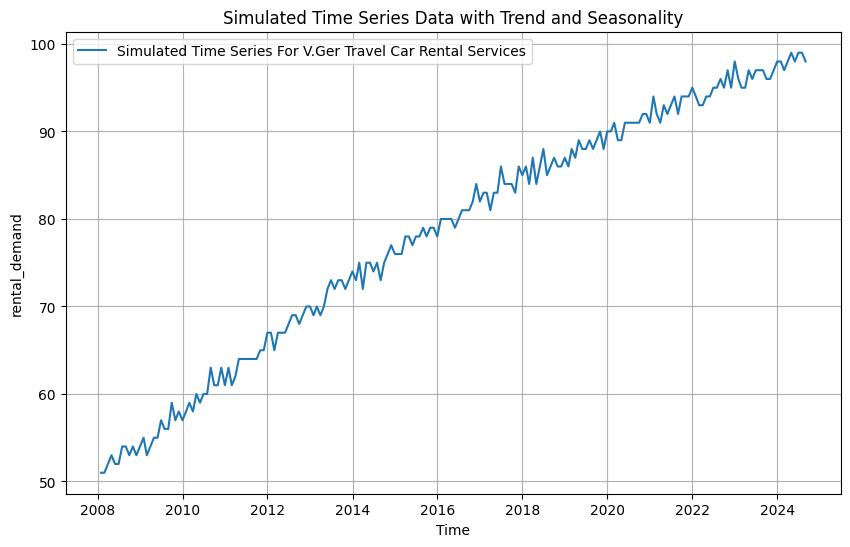

Time series data saved to 'generated_time_series.csv'.


In [5]:
n_periods=200
frequency='months'
trend_slope=0.25
seasonal_period='annual'
seasonal_amplitude= 5
noise_level=0.9
base_demand = 50
start_date = '2008-01-01'
x_col, y_col = 'Time', 'rental_demand'
file_name = 'generated_time_series.csv'
col_data = 'car_type'
col_map = 'base_cost'
col_apply = 'brand'


time_series_generator = TimeSeriesGenerator(n_periods, frequency, trend_slope, seasonal_period, seasonal_amplitude, noise_level, base_demand)
car_rental = carRentalTimeSeries()
data_frame_generator = dataFrameGenerator()
car_rental_data = carRentalData(time_series_generator, data_frame_generator, n_periods, start_date, col_data, col_map, col_apply)

df = car_rental.generate_car_rental_time_series(car_rental_data, x_col, y_col)
time_series_generator.plot_time_series(df, x_col, y_col)
time_series_generator.save_to_csv(df, file_name)



In [33]:
df.head()

,rental_demand,car_type,base_cost,brand
Time,,,,
2008-01-31,51.0,SUV,70,Chevrolet
2008-02-29,51.0,Luxury,100,Mercedes
2008-03-31,52.0,Compact,30,Toyota
2008-04-30,53.0,SUV,70,Jeep
2008-05-31,52.0,SUV,70,Ford


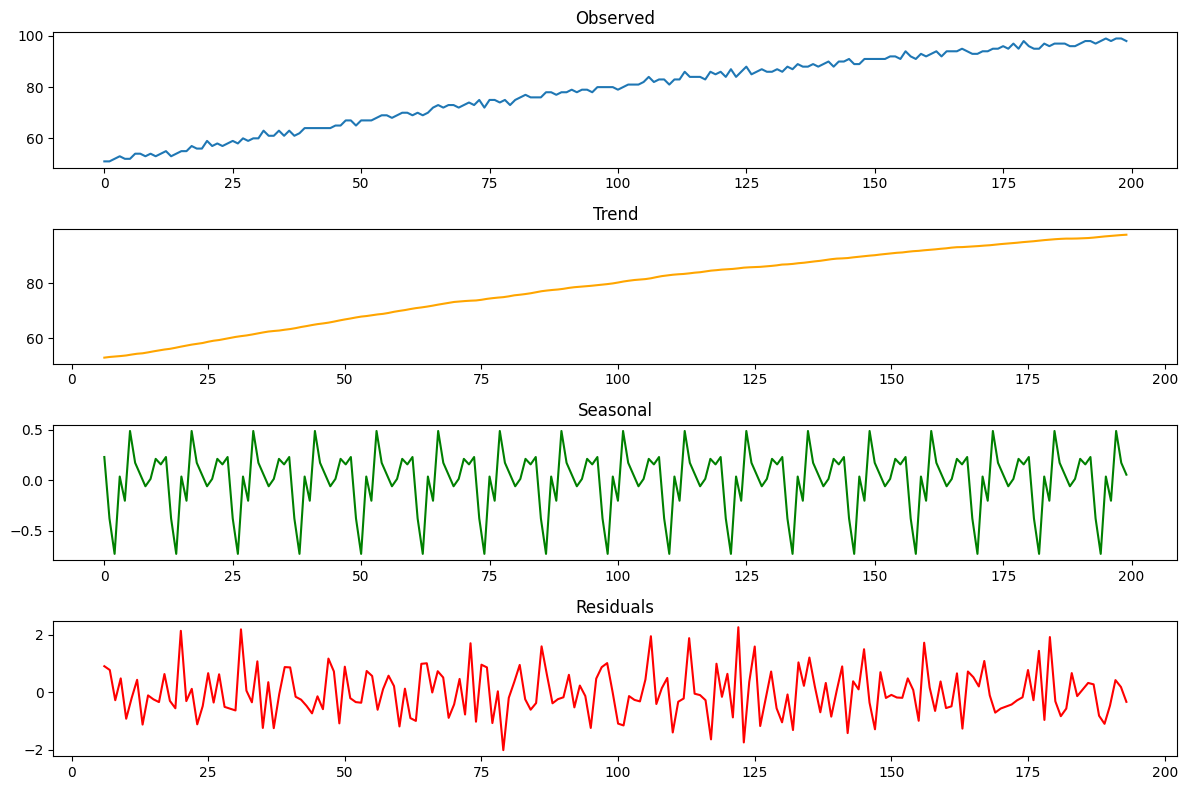

In [6]:
decomposition = time_series_generator.decompose_time_series(df, x_col, y_col)

time_series_generator.plot_decomposition(decomposition)

In [7]:
# file_name = 'generated_car_rental.csv'
file_name = 'generated_time_series.csv'
car_rental_df = pd.read_csv(file_name)
car_rental_df[x_col] = pd.to_datetime(car_rental_df[x_col])
car_rental_df.set_index(x_col, inplace=True)
car_rental_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2008-01-31 to 2024-08-31
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rental_demand  200 non-null    float64
 1   car_type       200 non-null    object 
 2   base_cost      200 non-null    int64  
 3   brand          200 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 7.8+ KB


In [8]:
#plot pacf and acf to determine potential order of p

def plot_fn(df: pd.DataFrame, y_col: str, plot_fn, title: str, x_label: str, y_label: str, lags: int=0):
  plt.figure(figsize=(12, 6))
  if lags:
    plot_fn(df[y_col], lags=lags)
  else:
    plot_fn(df[y_col])

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.grid(True)
  plt.tight_layout()
  plt.show()




In [9]:
#plot data

y_col = 'rental_demand'
plot = plt.plot
title = "Rental Demand"
x_label = "Date"
y_label = "Rental Demand"
acf = plot_acf

# plot_fn(car_rental_df, y_col, plot, title, x_label, y_label)


<Figure size 1200x600 with 0 Axes>

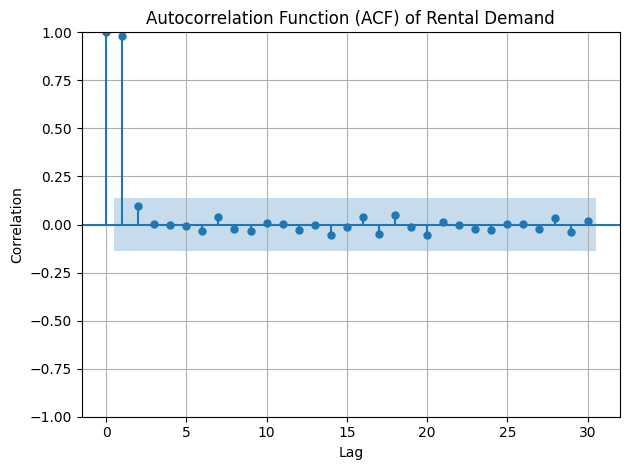

In [10]:
title = "Autocorrelation Function (ACF) of Rental Demand"
x_label = "Lag"
y_label = "Correlation"

plot_fn(car_rental_df, y_col, plot_pacf, title, x_label, y_label, lags=30)
# plot_fn(car_rental_df, y_col, plot_acf, title, x_label, y_label, lags=30)


We observe significant spikes (going beyond the confidence bands) at lags 1, 2, to 6 and 10. This suggests that there is a strong correlation between rental demand at the current time and its values 1, 2, 3, 4, 5, 6 and 10 periods ago.

Potential Seasonality: The spike at lag 10 strongly indicates a yearly seasonal pattern in rental demand. This is expected as rental demand typically fluctuates throughout the year due to factors like holidays, weather, and tourism seasons.

In [11]:
#test for stationarity
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def is_stationary(df:pd.DataFrame, y_col: str) -> bool:
  adfuller_result = adfuller(df[y_col])
  print(f'ADF Statistic: {adfuller_result[0]}')
  print(f'p-value: {adfuller_result[1]}')
  print(f'Critical Values: {adfuller_result[4]}')
  return "stationary" if adfuller_result[1] <= 0.05 else "non-stationary"

is_stationary(car_rental_df, y_col)

ADF Statistic: -4.716680545880197
p-value: 7.82862007509124e-05
Critical Values: {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}


'stationary'

In [12]:
size = int(0.85*len(car_rental_df))
df = car_rental_df[:size]

In [13]:
# Fit the SARIMA model with automatic parameter selection

car_rental_sarima_model = pm.auto_arima(
    df[y_col],
    start_p=0, max_p=3,            # Non-seasonal AR terms
    start_q=0, max_q=3,            # Non-seasonal MA terms
    start_P=1, max_P=3,            # Seasonal AR terms
    start_Q=1, max_Q=3,            # Seasonal MA terms
    d=1,                           # Differencing order
    D=1,                           # Seasonal differencing order
    m=12,                          # Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,                 # Enable seasonality
    stepwise=True,                 # Enable stepwise search
    trace=True,                    # Output model selection details
    information_criterion='aic'    # Criterion for model selection
)

Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.91 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=666.935, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=568.788, Time=1.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=605.757, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=546.888, Time=2.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[12]             : AIC=533.777, Time=2.76 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,1)[12]             : AIC=524.509, Time=9.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=523.113, Time=3.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,2)[12]             : AIC=524.630, Time=6.87 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.66 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,2)[12]             : AIC=526.505, Time=4.41 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=4.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,1)[12]             : AIC=494.112, Time=4.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=6.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[12]             : AIC=520.410, Time=2.70 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(3,1,1)[12]             : AIC=494.678, Time=8.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,2)[12]             : AIC=494.527, Time=10.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[12]             : AIC=541.554, Time=0.21 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=4.51 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(3,1,0)[12]             : AIC=504.777, Time=1.01 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(3,1,2)[12]             : AIC=496.369, Time=7.27 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,1,1)[12]             : AIC=492.557, Time=1.60 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=1.96 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,1,0)[12]             : AIC=519.622, Time=0.45 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(3,1,1)[12]             : AIC=492.975, Time=2.77 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,1,2)[12]             : AIC=492.666, Time=7.84 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,0)[12]             : AIC=540.956, Time=0.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,2)[12]             : AIC=inf, Time=4.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(3,1,0)[12]             : AIC=504.390, Time=1.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(3,1,2)[12]             : AIC=494.415, Time=8.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,1)[12]             : AIC=480.942, Time=1.99 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,1)[12]             : AIC=481.242, Time=1.01 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=497.453, Time=0.90 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(3,1,1)[12]             : AIC=481.797, Time=4.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,2)[12]             : AIC=481.452, Time=6.69 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=517.657, Time=0.46 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,2)[12]             : AIC=480.901, Time=5.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,2)[12]             : AIC=481.036, Time=1.72 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,3)[12]             : AIC=481.682, Time=10.68 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,1)[12]             : AIC=inf, Time=0.98 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,3)[12]             : AIC=480.071, Time=3.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,3)[12]             : AIC=478.193, Time=5.43 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,2)[12]             : AIC=479.125, Time=1.43 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,3)[12]             : AIC=479.830, Time=6.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,2)[12]             : AIC=479.030, Time=7.82 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,3)[12]             : AIC=478.228, Time=2.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,3)[12]             : AIC=493.304, Time=1.63 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,3)[12]             : AIC=inf, Time=10.57 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,3)[12]             : AIC=522.875, Time=1.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,3)[12]             : AIC=469.750, Time=5.85 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=6.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,3)[12]             : AIC=inf, Time=8.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,2)[12]             : AIC=inf, Time=8.36 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,3)[12]             : AIC=476.913, Time=2.02 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,3)[12]             : AIC=inf, Time=10.89 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,3)[12]             : AIC=481.171, Time=1.65 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,1,3)[12]             : AIC=477.383, Time=2.88 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,1,3)[12]             : AIC=inf, Time=14.60 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,3)[12] intercept   : AIC=inf, Time=10.74 sec

Best model:  ARIMA(1,1,2)(0,1,3)[12]          
Total fit time: 268.511 seconds


In [14]:
car_rental_sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  170
Model:             SARIMAX(1, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood                -227.875
Date:                                    Fri, 27 Dec 2024   AIC                            469.750
Time:                                            16:53:30   BIC                            491.144
Sample:                                        01-31-2008   HQIC                           478.439
                                             - 02-28-2022                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9909      0.017     57.455      0.000       0.957       1.025
ma.L1         -1.9032      0.042    -45.657      0.000      -1.985      -1.822
ma.L2          0.9155      0.041     22.082      0.000       0.834       0.997
ma.S.L12      -1.0514      0.109     -9.621      0.000      -1.266      -0.837
ma.S.L24       0.0050      0.125      0.040      0.968      -0.241       0.251
ma.S.L36       0.1573      0.119      1.326      0.185      -0.075       0.390
sigma2         0.9174      0.106      8.685      0.000       0.710       1.124
===================================================================================
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.23   Prob(JB):                         0.76
Heteroskedasticity (H):               1.24   Skew:                             0.02
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Key Information:

Model: SARIMAX(1, 1, 2)
This indicates that the model is a Seasonal Autoregressive Integrated Moving Average model.
(2, 1, 2) represents the non-seasonal ARIMA parameters:
AR order (p) = 2
Differencing order (d) = 1
MA order (q) = 2
Log Likelihood: -232.258 - A measure of the model's fit to the data. Higher values generally indicate a better fit.
AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), HQIC (Hannan-Quinn Information Criterion): Model selection criteria. Lower values generally indicate a better model.
Covariance Type: 'opg' - This likely refers to the covariance type used in the estimation process.
Coefficient Table:

intercept: A constant term in the model.
ar.L1, ar.L2: Autoregressive coefficients at lags 1 and 2.
ma.L1, ma.L2: Moving average coefficients at lags 1 and 2.
sigma2: The estimated variance of the error term.
Diagnostic Tests:

Ljung-Box Test (Q):
Tests the null hypothesis that the residuals are serially uncorrelated.
A high p-value (0.97) suggests that there is no significant autocorrelation in the residuals, indicating a good model fit.
Jarque-Bera Test (JB):
Tests the null hypothesis that the residuals are normally distributed.
A high p-value (0.40) indicates that the residuals are not significantly different from a normal distribution.
Heteroskedasticity Test (H):
Tests for heteroscedasticity (non-constant variance) in the residuals.
A high p-value (0.69) suggests that there is no significant heteroscedasticity.
Skew and Kurtosis:
These measures describe the shape of the residual distribution.
Skew = 0.12 suggests a slight positive skew.
Kurtosis = 3.45 is close to the normal distribution's kurtosis (3), indicating a relatively normal shape.
Overall Interpretation:

Based on the provided results, the SARIMAX(2, 1, 2) model appears to be a reasonable fit for the data.

The model has a relatively low AIC, BIC, and HQIC values.
The diagnostic tests (Ljung-Box, Jarque-Bera, and Heteroskedasticity) indicate that the model residuals are likely uncorrelated, normally distributed, and have constant variance.
However, it's important to consider the context of the data and perform further analysis (e.g., cross-validation, residual plots, forecast evaluation) to ensure the model's accuracy and reliability for prediction.

<Figure size 1200x600 with 0 Axes>

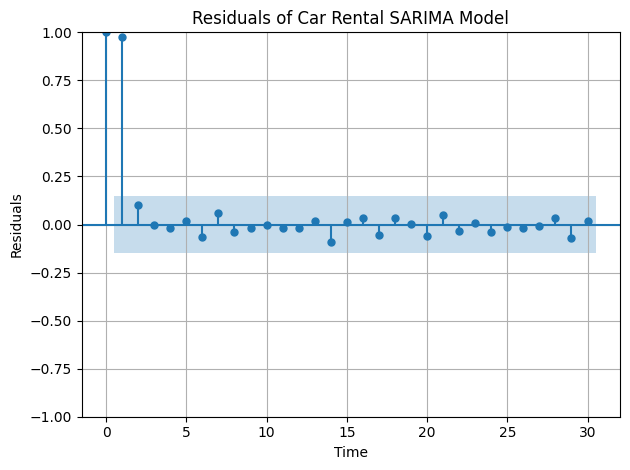

In [15]:
residual = car_rental_sarima_model.arima_res_.resid

title = "Residuals of Car Rental SARIMA Model"
x_label = "Time"
y_label = "Residuals"

plot_fn(df, y_col, plot_pacf, title, x_label, y_label, lags=30)

Majority of the data points are within the confidence intervals, sugessting lack of significant auto correlations at most lags. This indicates a good fit of the model to the data points.

This was achieved after various customizations of the sarima parameters. The values of the lowest AIC and BIC achievesd, were

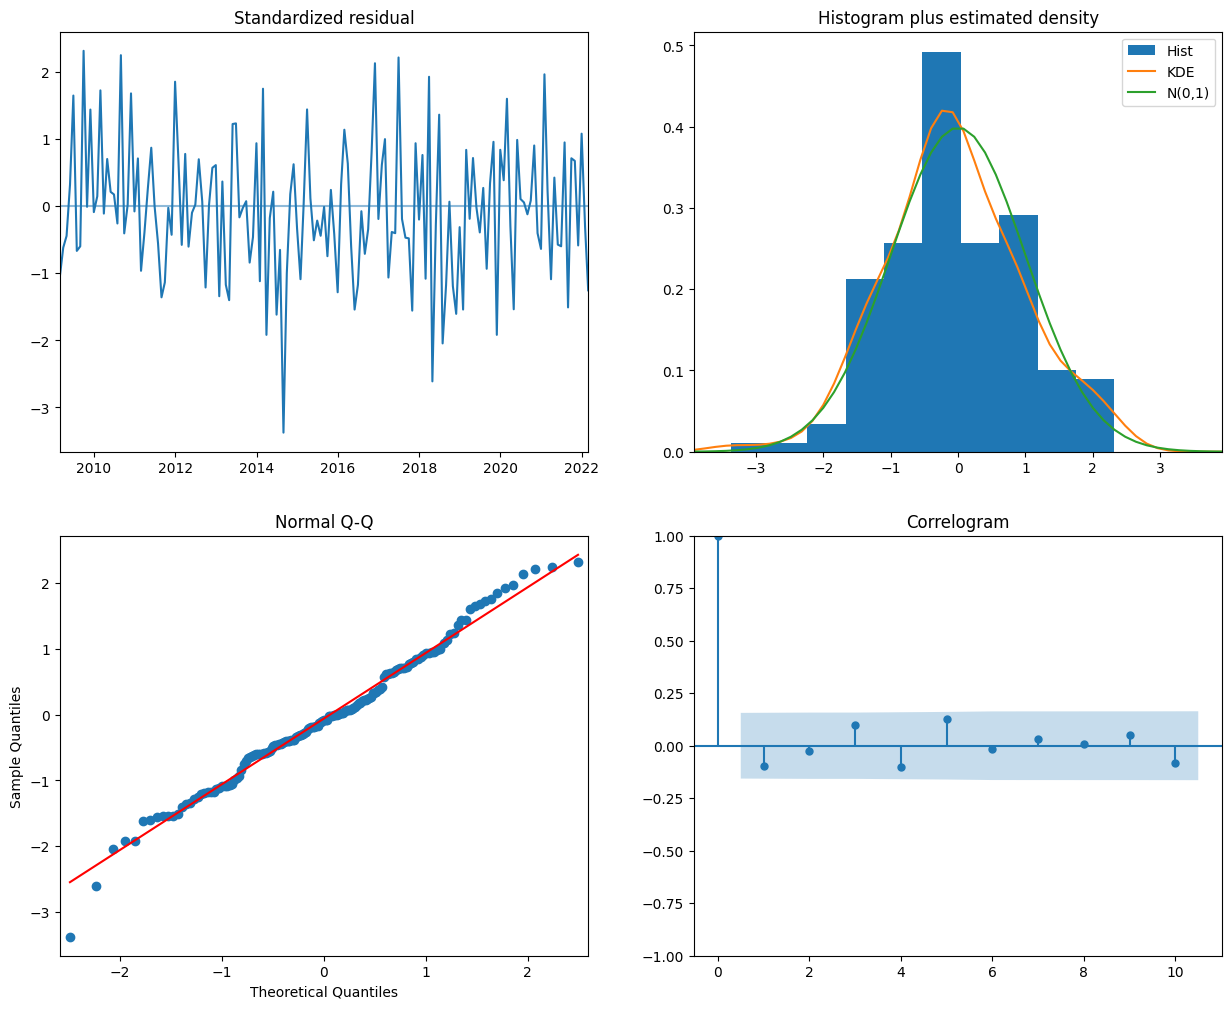

In [16]:
#forecast future data.
car_rental_sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [17]:
#forecast months ahead demand

m_periods = n_periods - size
forecast, conf_int = car_rental_sarima_model.predict(m_periods, return_conf_int=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [18]:
# Create a range of dates for the forecasted values

forecast_dates = pd.date_range(start=car_rental_df.index[size-1], periods=m_periods+1, freq='M')[1:]
# forecast_dates = pd.date_range(start=df.index[size-1], periods=m_periods + 1, freq='M')[1:]

<ipython-input-18-fd57cc6a255b>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=car_rental_df.index[size-1], periods=m_periods+1, freq='M')[1:]


In [19]:
# visualize data

def plot_data(df: pd.DataFrame, title: str, x_label: str, y_label: str, grid: bool, fig: Tuple[int, int], conf_interval: np.ndarray, *args, **kwargs):
  plt.figure(figsize=fig)
  for arg in args:
    if isinstance(arg, str):
      plt.plot(df[arg], label=kwargs.get(arg)[0], color=kwargs.get(arg)[1])
    else:
      plt.plot(arg, kwargs.get("forecast")[2], label=kwargs.get("forecast")[0], color=kwargs.get("forecast")[1])

  if len(conf_interval):
    plt.fill_between(forecast_dates, conf_interval[:, 0], conf_interval[:, 1], color='orange', alpha=0.3)

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.tight_layout()
  plt.grid(grid)
  plt.show()

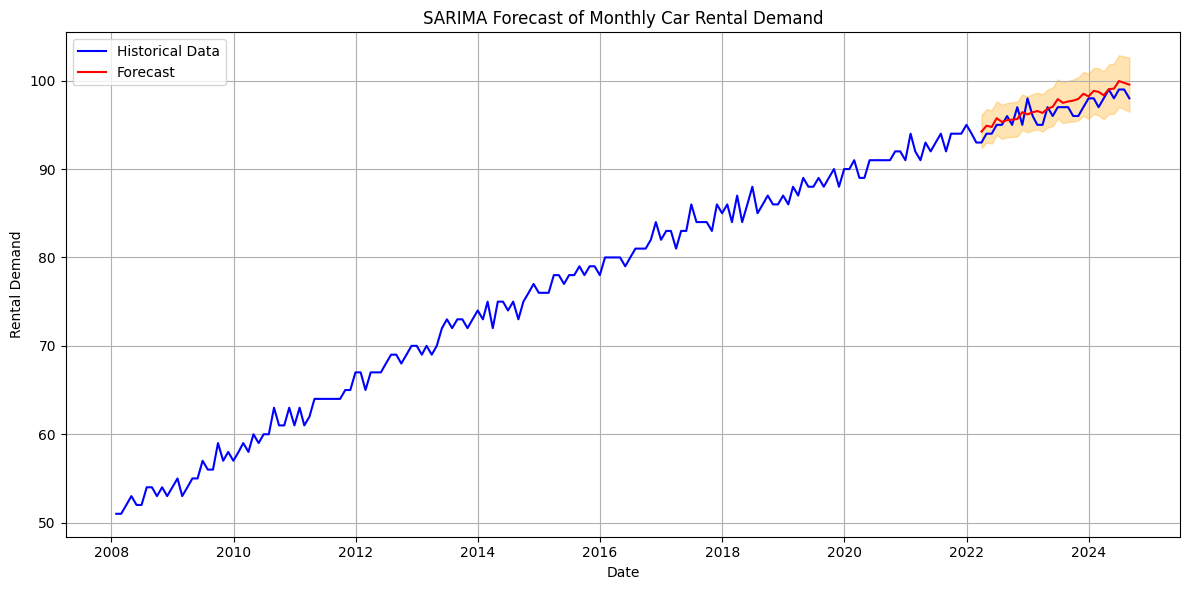

In [20]:
# Plot historical data and the forecast with confidence intervals
title = 'SARIMA Forecast of Monthly Car Rental Demand'
x_label = 'Date'
y_label = 'Rental Demand'
grid = True
fig = (12, 6)
kwargs = {
    y_col: ('Historical Data', 'blue'),
    "forecast" : ('Forecast', 'red', forecast)
}
args = [y_col, forecast_dates]

plot_data(car_rental_df, title, 'Date', 'Rental Demand', grid, fig, conf_int, *args, **kwargs)


In [21]:
#mean absolute error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

def calculate_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)

  return mae, mse, rmse


In [22]:
mae, mse, rmse = calculate_metrics(car_rental_df[y_col][size:], forecast[: m_periods])

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 0.9646904487824902
Mean Squared Error: 1.213711438560594
Root Mean Squared Error: 1.1016857258586017


Observations:

Historical Data: The blue line represents the historical car rental demand data. It shows an upward trend with some seasonal fluctuations.

Forecast: The red line represents the forecasted car rental demand. It extends from and beyond the historical data, indicating past and future predictions respectively.

Confidence Interval: The orange area around the forecast line represents the confidence interval for the forecast. This interval indicates the range within which the actual demand is likely to fall with a certain level of probability (95% in this case). We can see that the past predictions fall within the confidence interval, giving our predictions a high probability of correctness.

Interpretation:

Upward Trend: The historical data and the forecast both suggest an upward trend in car rental demand over time. This could be attributed to factors like population growth, economic growth, or increasing tourism or GDP. There is also the possibility that the public transport system is under performing.

Seasonality: The historical data exhibits clear seasonal fluctuations. This is likely due to factors like variations in weather, holidays, festivals, and travel seasons. The SARIMA model attempts to capture these seasonal patterns and incorporate them into the forecast.

Forecast Uncertainty: The confidence interval around the forecast diverges as we move further into the future. This is an indication that the uncertainty associated with the forecast increases with the forecast horizon.

Overall:

The plot suggests that the SARIMA model has captured the underlying trend and seasonality in the historical data and provides a reasonable forecast of future car rental demand. However, it's important to remember that the forecast is based on assumptions and historical data, and actual demand may deviate from the forecast due to unforeseen events or changing circumstances.

Further Considerations:

Model Evaluation:
Exogenous Variables: Relevant exogenous variables such as fuel prices, GDP, per capita income, annual income, debt can act as economic indicators, which can affect the demand for car rentals. Incorporating these into the model could potentially improve forecast accuracy.

Further to this, we will be introducing fuel prices as an exogenous variable.

In [23]:
# Generate fuel price data with some trend and seasonality
np.random.seed(42)
fuel_price = 50 + 2 * np.sin(np.linspace(0, 3 * np.pi, n_periods)) + np.random.normal(0, 1, n_periods)
fuel_price = np.clip(fuel_price, 0, 100)



In [24]:
data_frame_generator.create_column_data(car_rental_df, 'fuel_price', fuel_price)
# car_rental_df.head(2)

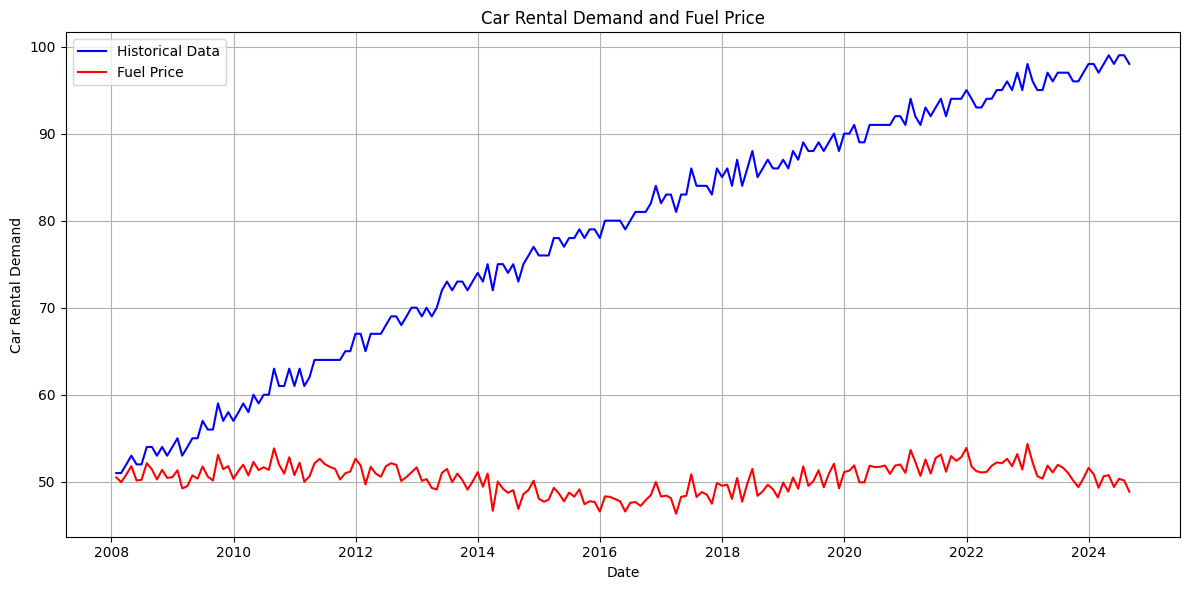

In [25]:
kwargs = {
     y_col: ('Historical Data', 'blue'),
    'fuel_price': ('Fuel Price', 'red')
}
title = "Car Rental Demand and Fuel Price"
x_label = "Date"
y_label = "Car Rental Demand"
grid = True
fig = (12, 6)

plot_data(car_rental_df, title, x_label, y_label, grid, fig, [], *kwargs.keys(), **kwargs)


In [26]:
# Fit SARIMAX model with fuel price as an exogenous variable
sarimax_model = SARIMAX(
    car_rental_df[y_col][:size],
    order=(1, 1, 0),               # ARIMA(p, d, q) parameters
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, S) parameters
    enforce_stationarity=True,    # Set to True if you want to enforce stationarity
    exog=car_rental_df['fuel_price'][:size] # Exogenous variable: Fuel Price
)
sarimax_results = sarimax_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


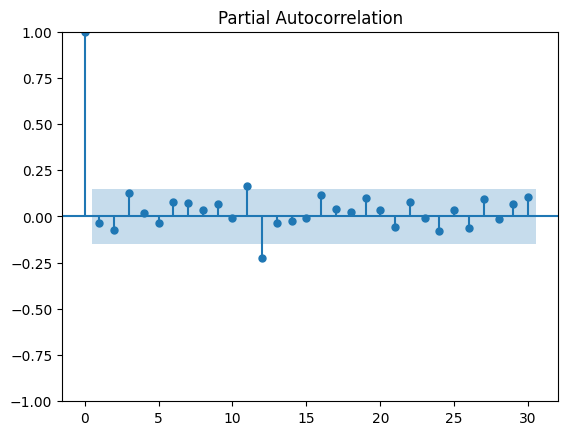

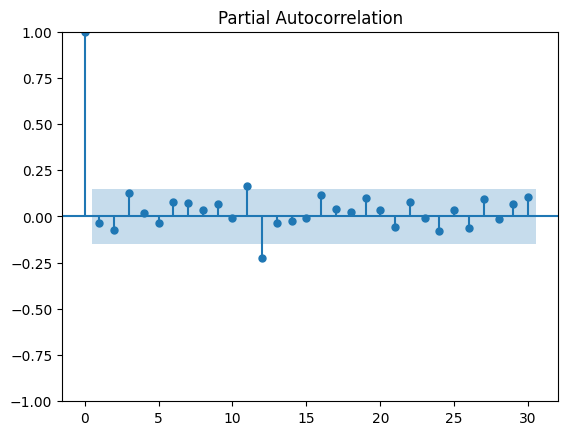

In [27]:
sarimax_results.summary()
# sarimax_results.resid
plot_pacf(sarimax_results.resid, lags=30)

In [28]:
# Forecast future values
# m_periods = 24  # Forecast for 1 year ahead
np.random.seed(42)
future_fuel_price = 50 + 2 * np.sin(np.linspace(3 * np.pi, 4 * np.pi, m_periods)) + np.random.normal(0, 1, m_periods)
future_fuel_price = np.clip(future_fuel_price, 0, 100)

In [29]:

# Make predictions
sarimax_model_forecast_exg = sarimax_results.get_forecast(steps=m_periods, exog=future_fuel_price.reshape(-1, 1))
forecast_index = pd.date_range(car_rental_df.index[size-1], periods=m_periods+1, freq='ME')[1:]
forecast_conf_int = sarimax_model_forecast_exg.conf_int()

In [30]:
# display(forecast.predicted_mean, car_rental_df.index[size:])
# display(forecast_conf_int.to_numpy(), conf_int)


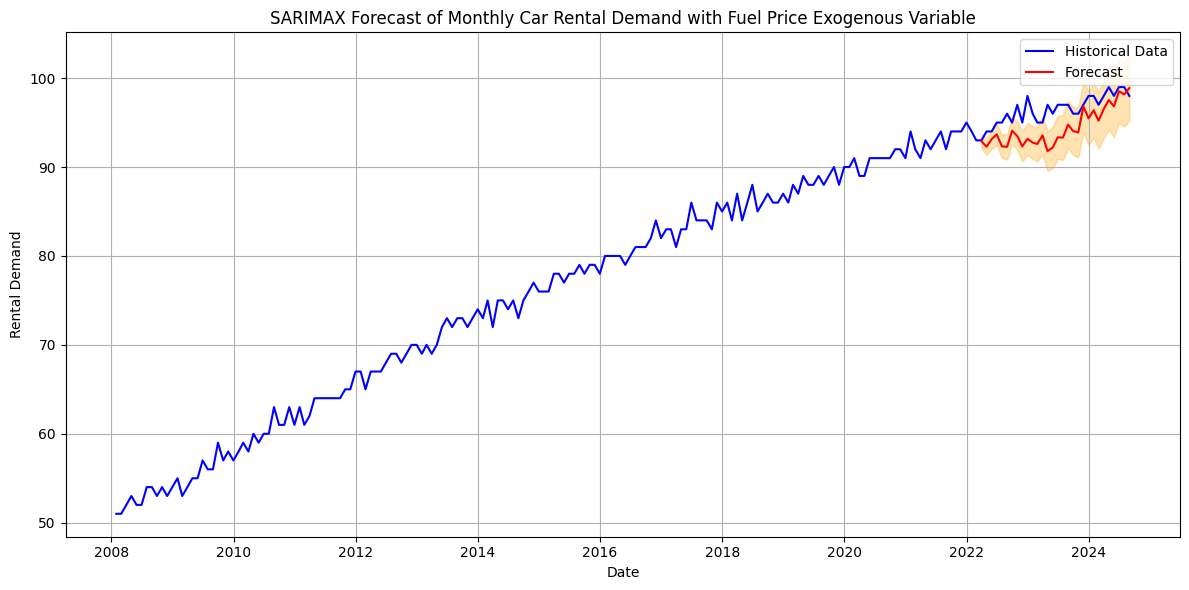

In [31]:
# Plot forecast

title = 'SARIMAX Forecast of Monthly Car Rental Demand with Fuel Price Exogenous Variable'
kwargs = {
    y_col: ('Historical Data', 'blue'),
    "forecast" : ('Forecast', 'red', sarimax_model_forecast_exg.predicted_mean)
}
args = [y_col, forecast_index]

plot_data(car_rental_df, title, 'Date', 'Rental Demand', grid, fig, forecast_conf_int.to_numpy(), *args, **kwargs)




In [32]:
mae, mse, rmse = calculate_metrics(car_rental_df[y_col][size:], forecast.predicted_mean[: n_periods-size])
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

AttributeError: 'Series' object has no attribute 'predicted_mean'

1. n_periods (Number of Time Steps)

    Description: Specifies how many data points you want to generate.
    Usage: Affects the length of the time series.
    Example Values:
        n_periods=100 for a short time series.
        n_periods=500 for a longer time series.
    Default: 100.

2. frequency (Time Frequency)

    Description: Defines the time intervals of the series.
    Options:
        'days': Daily time intervals.
        'weeks': Weekly time intervals.
        'months': Monthly time intervals.
    Usage: Determines the time range of the time series.
    Example Values:
        frequency='days' for daily observations.
        frequency='weeks' for weekly data.
        frequency='months' for monthly data.
    Default: 'days'.

3. trend_slope (Linear Trend Slope)

    Description: Controls how quickly the trend increases over time.
    Usage: Affects the magnitude of the overall increase in the series.
    Example Values:
        trend_slope=0.1: A slow-growing trend.
        trend_slope=0.5: A faster-growing trend.
        trend_slope=0: No trend (flat).
    Default: 0.3.

4. seasonal_period (Seasonal Pattern)

    Description: Specifies the type of seasonality to include in the series.
    Options:
        'monthly': Seasonal variations occur every 12 periods (e.g., months in a year).
        'weekly': Seasonal variations occur every 52 periods (e.g., weeks in a year).
        'annual': Seasonal variations occur every 365 periods (e.g., days in a year).
    Usage: Adjust this to reflect real-world seasonality based on the data's frequency.
    Example Values:
        seasonal_period='monthly' for sales data.
        seasonal_period='weekly' for weekly activity patterns.
        seasonal_period='annual' for long-term trends.
    Default: 'monthly'.

5. seasonal_amplitude (Strength of Seasonality)

    Description: Controls the magnitude of the seasonal fluctuations.
    Usage: Sets the "height" of seasonal oscillations relative to the trend.
    Example Values:
        seasonal_amplitude=2: Subtle seasonal variation.
        seasonal_amplitude=10: Strong seasonal variation.
    Default: 5.

6. noise_level (Random Variation)

    Description: Adds random noise to simulate natural variability in the data.
    Usage: Higher values create noisier data, while lower values make it smoother.
    Example Values:
        noise_level=0: No noise.
        noise_level=0.5: Moderate noise.
        noise_level=2: High noise.
    Default: 0.5.

Tips for Setting Parameters:

    Match Seasonality to Frequency: Ensure that the seasonal_period makes sense for the chosen frequency.
        Example: For frequency='months', use seasonal_period='monthly' for realistic results.
    Control Noise for Clarity: Use noise_level=0 for clean series or increase it slightly (e.g., 0.2) to simulate real-world randomness.
    Trend Dominance: Ensure the trend_slope is much larger than seasonal_amplitude if you want the trend to dominate over seasonality.